<a href="https://colab.research.google.com/github/KaranPrajapati8750/Digit_Mnist-8k_params-/blob/main/Digit_Mnist(8k_params).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random

import numpy as np
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def preprocess_data(X, normalize=True):
    X = X.astype('float32')

    if normalize:
        X /= 255.

    return X.reshape(*X.shape, 1)

In [4]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

X_train = preprocess_data(X_train)
X_valid = preprocess_data(X_valid)

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [5]:
def cnn_8k(optim='adam', loss='categorical_crossentropy'):
  
    net = Sequential(name='cnn_8k')

    net.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=(img_width, img_height, img_depth),
            name='conv2d_1'
        )
    )
    net.add(LeakyReLU(name='leaky_relu_1'))
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(MaxPooling2D(pool_size=(2,2), name='max_pool_1'))

    net.add(
        Conv2D(
            filters=14,
            kernel_size=(3,3),
            name='conv2d_2'
        )
    )
    net.add(LeakyReLU(name='leaky_relu_2'))
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2,2), name='max_pool_2'))

    net.add(Flatten(name='flatten_layer'))
    net.add(Dropout(0.2, name='dropout_1'))
    net.add(Dense(num_classes, activation='softmax', name='dense_out'))
    
    net.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    return net

In [6]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    min_delta=0.00005,
    baseline=0.98,
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=4,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [7]:
loss = 'categorical_crossentropy'
optim = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
batch_size = 128
epochs = 40

model = cnn_8k(optim, loss)
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "cnn_8k"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 26, 26, 32)        0         
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 26, 26, 32)        128       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 14)        4046      
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 11, 11, 14)        0         
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 11, 11, 14)        56   

In [8]:
sns.set()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

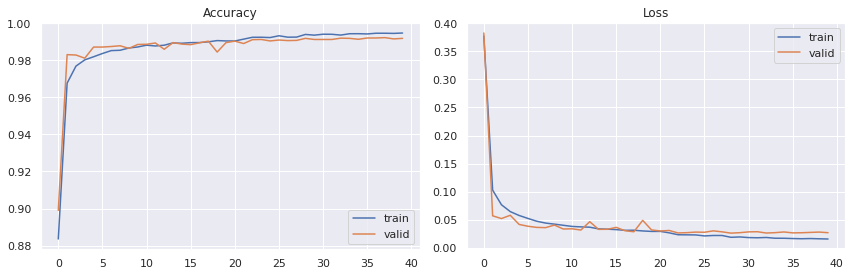

In [9]:
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()